In [24]:
import sys; sys.path.append('../util')
from load_yelp_data import load_yelp_dataframe, restaurants_and_bars_in, train_test_split_reviews
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics
import scipy.optimize
%matplotlib inline

from baseline_calculator import *
from simple_averaging_recommender import SimpleAveragingRecommender

In [2]:
businesses = load_yelp_dataframe('businesses')
reviews = load_yelp_dataframe('reviews')
users = load_yelp_dataframe('users')

In [3]:
phoenix_restaurants, phoenix_reviews, phoenix_users = restaurants_and_bars_in('Phoenix', businesses, reviews, users)

In [4]:
def X_and_y_of(df):
    return df[['user_id', 'business_id']].values, df['stars'].values

reviews_train, reviews_test = train_test_split_reviews(phoenix_reviews)

X_train, y_train = X_and_y_of(reviews_train)
X_test, y_test = X_and_y_of(reviews_test)

In [5]:
def summarize_performance(model):
    name = model.__class__.__name__
    print '{} train RMSE: {}'.format(name, model.rmse(X_train, y_train))
    print '{} test RMSE: {}'.format(name, model.rmse(X_test, y_test))

In [6]:
simple_avg = SimpleAveragingRecommender()
simple_avg.fit(X_train, y_train)
summarize_performance(simple_avg)

SimpleAveragingRecommender train RMSE: 0.976644727132
SimpleAveragingRecommender test RMSE: 1.34699149129


In [7]:
sabc = SimpleAverageBaselineCalculator()
sabc.fit(reviews_train)
sabc_train_rmse = sabc.baseline_rmse(reviews_train)
sabc_test_rmse = sabc.baseline_rmse(reviews_test)
print(sabc_train_rmse)
print(sabc_test_rmse)

0.940713121422
1.32249849984


In [8]:
ambc = AbsoluteMeanBaselineCalculator()
ambc.fit(reviews_train)
ambc_train_rmse = ambc.baseline_rmse(reviews_train)
ambc_test_rmse = ambc.baseline_rmse(reviews_test)
print(ambc_train_rmse)
print(ambc_test_rmse)

1.35148870051
1.35392475252


In [20]:
bpbc = BetaPriorBaselineCalculator()
prior_strs = list(np.arange(2, 50, 1)) + list(np.arange(51, 301, 10))
train_rmses = []
test_rmses = []
for prior_strength in prior_strs:
    bpbc.fit(reviews_train, prior_strength=prior_strength)
    train_rmses.append(bpbc.baseline_rmse(reviews_train))
    test_rmses.append(bpbc.baseline_rmse(reviews_test))

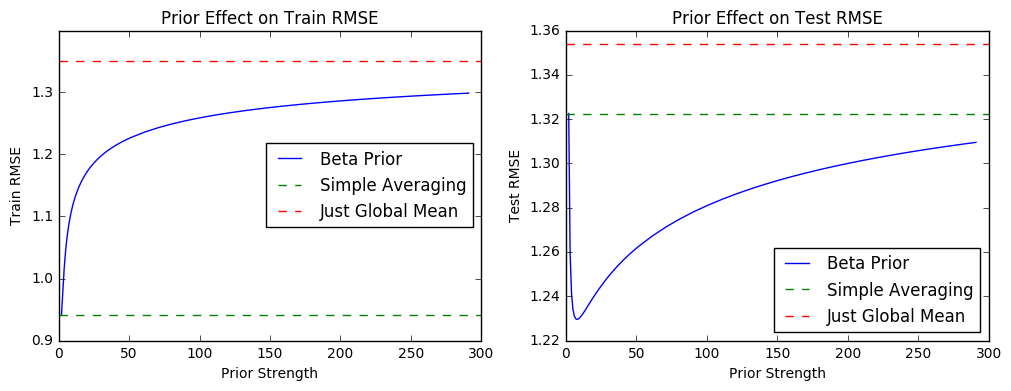

In [21]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(121)
plt.title('Prior Effect on Train RMSE')
plt.ylabel('Train RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, train_rmses, label='Beta Prior')
plt.axhline(sabc_train_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_train_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

fig.add_subplot(122)
plt.title('Prior Effect on Test RMSE')
plt.ylabel('Test RMSE')
plt.xlabel('Prior Strength')
plt.plot(prior_strs, test_rmses, label='Beta Prior')
plt.axhline(sabc_test_rmse, label='Simple Averaging', ls='--', color='green')
plt.axhline(ambc_test_rmse, label='Just Global Mean', ls='--', color='red')
plt.legend(loc='best')

plt.show()

In [23]:
prior_strs[np.argmin(test_rmses)]

8

First thing to note -- we actually would have gotten a lower RMSE than simple averaging had we just predicted the global mean for every restaurant. That means our baseline models were actually extremely terrible.

Second thing to note -- our beta priors make sense, because when our prior strength is minimal (at a=b=1, which describes a uniform prior), our RMSE matches simple averaging exactly, and when our prior strength $\to \infty$, it matches just predicting the global mean everywhere. This is good to note! 

In [12]:
sabc = SimpleAverageBaselineCalculator()
sabc.fit(reviews_train)
sabc.transform(reviews_train)
inv = sabc.inverse_transform(reviews_train, reviews_train.starz)
np.testing.assert_array_almost_equal(inv, reviews_train.stars)

In [ ]:
subs = reviews_train[['stars', 'user_id', 'business_id']].values
busi_indexes = {}
user_indexes = {}
user_ids = reviews_train.user_id.unique()
busi_ids = reviews_train.business_id.unique()
mu = reviews_train.stars.mean()
n_users = len(user_ids)
n_busis = len(busi_ids)
for i, u in enumerate(user_ids): user_indexes[u] = i
for i, b in enumerate(busi_ids): busi_indexes[b] = i

def loss(coefs):
    user_baselines = coefs[:n_users]
    busi_baselines = coefs[n_users:]
    
    sum_sq_error = sum(
        (stars - mu -
         user_baselines[user_indexes[u]] -
         busi_baselines[busi_indexes[b]])**2 for stars, u, b in subs)
    
    l2_penalty = np.sum(user_baselines**2) + np.sum(busi_baselines**2)
    
    return sum_sq_error + reg_strength*l2_penalty

# could also use stochastic gradient descent
initial_guess = np.zeros(n_users + n_busis)
result = scipy.optimize.minimize(loss, initial_guess, method='L-BFGS-B')